In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
import re
from natsort import natsorted
from sklearn.metrics import roc_curve, auc

In [2]:
# Accuracy function for BN
def get_acc_bn(data: pd.DataFrame, col: str, vs_col: str) -> float:

    return sum(data[col] == data[vs_col]) / len(data)

# Accuracy function for CN
def get_acc_cn(data: pd.DataFrame, col: str, vs_col: str) -> tuple:

    # Split results based on CN certainty
    cert_idx = data[(data['cn_probs'] > 0.5)].index
    data_cert = data.iloc[cert_idx]
    data_uncert = data[~data.index.isin(cert_idx)]

    # Compute accuracies
    acc_cn_cert = get_acc_bn(data_cert, col, vs_col) if len(data_cert) > 0 else None    
    acc_cn_uncert = get_acc_bn(data_uncert, col, vs_col) if len(data_cert) > 0 else None

    return acc_cn_cert, acc_cn_uncert

In [3]:
dirs = natsorted([dir for dir in os.listdir(".") if "results_" in dir])

res = {
    "ess": [],
    "eps": [],
    "acc_cn_cert": [],
    "acc_cn_uncert": [],
    "acc_cn_tot": [],
    "acc_noisy_bn": [],
    "cert_noisy_bn": [],
    "cert_cn": [],
}

for dir in dirs:

    # Get results 
    files = [f for f in os.listdir(dir) if ".csv" in f]
    r_concat = pd.concat([pd.read_csv(dir + "/" + f) for f in files])
    r_concat.reset_index(inplace = True)

    # Store ess
    reg = re.search("nodes(\d+)_ess(\d+)", dir)
    n_nodes = reg.group(1)
    ess = reg.group(2)

    # Store avg of eps
    with open(dir + "/exp_meta.txt", "r") as f:
        eps = [float(re.search("Eps: (.+)\n", line).group(1)) for line in f if "Eps: " in line]
        eps = float(np.mean(eps))

    # Compute accuracies
    vs = "gt"

    acc_cn_cert, acc_cn_uncert = get_acc_cn(r_concat, f"{vs}_mpes", "cn_mpes")
    acc_cn_tot = get_acc_bn(r_concat, f"{vs}_mpes", "cn_mpes")
    acc_noisy_bn = get_acc_bn(r_concat, f"{vs}_mpes", "bn_noisy_mpes")

    # Compute certainties
    cert_cn =sum(r_concat['cn_probs'] > 0.5) / len(r_concat)
    cert_noisy_bn =  sum(r_concat['bn_probs'] > 0.5) / len(r_concat)
    
    # Store results
    for key in res.keys():
        res[key].append(eval(key))

    # Debug
    assert(len(r_concat) == len(pd.read_csv(dir + "/" + files[0])) * len(files))

# Debug
length = len(res["ess"])
for key in res.keys():
    assert(len(res[key]) == length)

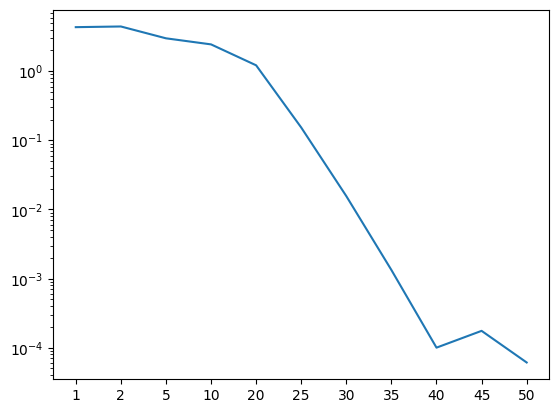

In [4]:
# ess vs eps
plt.semilogy(res["ess"], res["eps"])

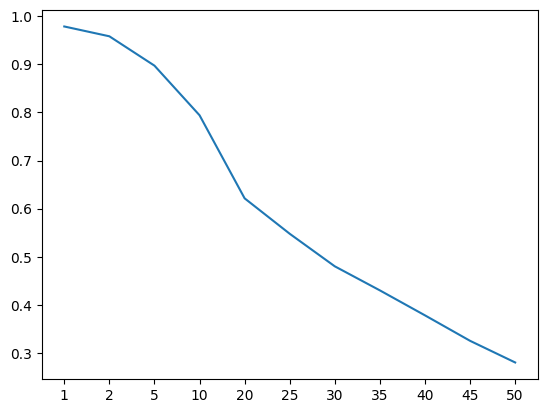

In [5]:
# ess vs CN certainty
plt.plot(res["ess"], res["cert_cn"])

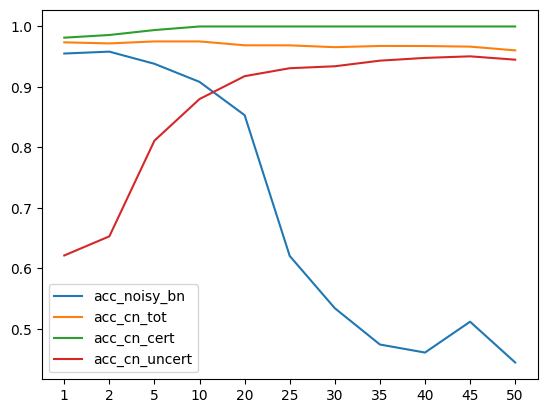

In [6]:
# Accuracies
labels = ["acc_noisy_bn", "acc_cn_tot", "acc_cn_cert", "acc_cn_uncert"]
for label in labels:
    plt.plot(res["ess"], res[label], label=label)
plt.legend()

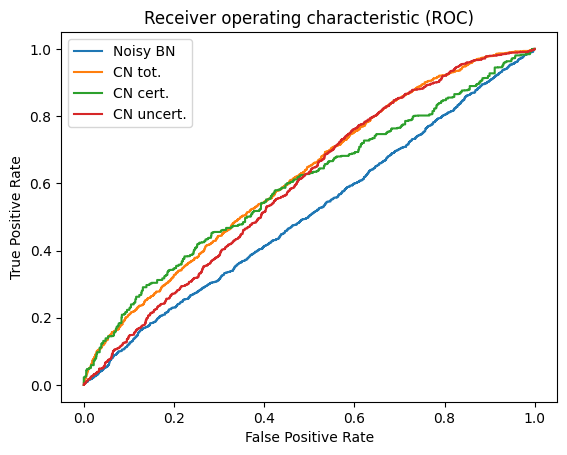

In [7]:
# ROC curves
fpr, tpr, _ = roc_curve(r_concat[f"{vs}_mpes"], r_concat["bn_probs"])
plt.plot(fpr, tpr, label="Noisy BN")
fpr, tpr, _ = roc_curve(r_concat[f"{vs}_mpes"], r_concat["cn_probs"])
plt.plot(fpr, tpr, label="CN tot.")
cert_idx = r_concat[(r_concat['cn_probs'] > 0.5)].index
r_concat_cert = r_concat.iloc[cert_idx]
r_concat_uncert = r_concat[~r_concat.index.isin(cert_idx)]
fpr, tpr, _ = roc_curve(r_concat_cert[f"{vs}_mpes"], r_concat_cert["cn_probs"])
plt.plot(fpr, tpr, label="CN cert.")
fpr, tpr, _ = roc_curve(r_concat_uncert[f"{vs}_mpes"], r_concat_uncert["cn_probs"])
plt.plot(fpr, tpr, label="CN uncert.")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="best")